# Detailed Tutorial

The LOFTI-Gaia package will fit orbital elements to the astrometry provided by Gaia EDR3 and DR2.

Written by Logan A. Pearce, 2020<br>
If you use LOFTI in your work please cite Pearce et al. 2020

## About LOFTI Gaia
LOFTI Gaia uses measurements from Gaia of resolved stellar binaries to provide loose constraint of orbital parameters for the pair.  It makes use of the Orbits for the Impatient (OFTI) methodology to accomplish the fit.  Care should be taken to understand the quality of the astrometric solution of the two objects before trying to apply the method.  It will give you answers, you should be sure the answers are somewhat reliable before trying to use the results.  Garbage in garbage out, as it were.  For a detailed discussion of when LOFTI results are and are not trustworthy, and how to approach making this assessment, please review Pearce et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020ApJ...894..115P/abstract)

## Initialize the fitter
And retrieve Gaia observational constraints

LOFTI takes only the Gaia source IDs of the two objects and their mass estimates as input parameters.  Mass is not taken as a free parameter and must be estimated via outside means.

Note: Gaia EDR3 source IDs may or may not be identical to the DR2 source IDs

For our test case, let's look at DS Tuc AB system.  DS Tuc A has a transiting exoplanet, as reported in Newton et al 2019 (https://ui.adsabs.harvard.edu/abs/2019ApJ...880L..17N/abstract).  Both DS Tuc A and B are well resolved in Gaia DR2, and both have radial velocity measurements as well.  It is an excellent demonstration case.  LOFTI was used in Newton et al. 2019 to show the binary orbit is broadly aligned with the transiting planet.  DS Tuc AB was used as the main demonstration case for the method in Pearce et al. 2020.

First we initialize the ```Fitter``` object.  This creates an object retrieves all the Gaia measurements for the system, computes the relative parameters for fitting the orbit, and some additional parameters for the system.  

In [1]:
# Gaia EDR3 source ids:
DSTucA = 6387058411482257536
DSTucB = 6387058411482257280
# Mass estimates, must be a tuple of (value,uncertainty)
# in solar masses:
massA = (0.97, 0.04)
massB = (0.87, 0.04)

# Import the Fitter and FitOrbit objects:
from lofti_gaiaEDR3 import Fitter, FitOrbit

# Initialize the fitter object:
fitterobject = Fitter(DSTucA,           # source id object 1
                      DSTucB,           # source id object 2
                      massA,            # mass object 1
                      massB,            # mass object 2
                      Norbits = 100,    # number of desired accepted orbits for the posterior orbit sample
                      catalog = 'gaiaedr3.gaia_source' # Select to pull astrometry from EDR3 or DR2 (Default: EDR3)
                     )


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


We can examine properties of the system by calling on the ```Fitter``` object.  All measurements are tuples of the form (value, uncertainty)<br>
For example:

In [2]:
# Proper motion of B relative to A in RA in km s^-1:
print(fitterobject.pmRA)
# Distance to system in pc:
print(fitterobject.distance)
# Relative separation in mas:
print(fitterobject.sep)
# Relative separation in AU:
print(fitterobject.sep_au)

[-0.3011447451027295, 0.004397055784004137]
(44.16211619501457, 0.029273518647388124)
(5365.593307350534, 0.015009308814395418)
(236.9559550944068, 0.0006628428398681868)


The RUWE parameter quantifies the quality of the astrometric solution.  If one of the objects has an RUWE > 1.2, the code will ask if you wish to proceed.  Results from fitting with RUWE >~ 1.2 should be interpretted with caution, and RUWE > 1.4 should not be relied upon to be accurate.

In [3]:
GL896A = 2824770686019003904
GL896B = 2824770686019004032
GL896fitterobject = Fitter(GL896A,GL896B,massA,massB,Norbits = 10)
print(GL896fitterobject.ruwe1,GL896fitterobject.ruwe2)

            that the source might be an unresolved binary or experiencing acceleration 
            during the observation.  Orbit fit results may not be trustworthy.
1.3173962 1.5881655


A complete list of the system parameters is found in the documentation for the Fitter object.

## Run the fit
Next, run the actual fit by calling ```FitOrbit``` and giving the ```Fitter``` object you just created as input.  The ```FitOrbit``` object will give a progress bar updating the progress towards reaching Norbits orbits in the sample.  The ```FitOrbit``` object contains the posterior orbit sample from the fit.

In [5]:
# run orbit fit:
orbits = FitOrbit(fitterobject)

Saving orbits in FitResults.2021.07.27.15.44.29.txt
inital chi min 22.35658986910957
100% (100 of 100): |####################|  Done...
Final Norbits: 100


Three files are written out during the fit: 
- 1. FitResults.yr.mo.day.hr.min.s.txt : this is a human readable file of accepted orbits in order: semimajoraxis(arcsec),    period(yrs]),    t_o(yr),    ecc,    incl(deg),    argofperiastron(deg]),    posangleofnodes(deg), chisquaredvalue,    proboforbit,    randnum<br>
- 2. FitResults.yr.mo.day.hr.min.s.pkl : machine readable binary file of orbit results which can be read using the LoadResults function (more below)<br>
- 3. FitResults.Stats.yr.mo.day.hr.min.s.txt : a human readable text file of summary statistics from the sample posterior.<br>

You can choose your own filename for these outputs with the ```results_filename``` attribute in the Fitter object.<br>


In [6]:
# The orbit object contains the parameters used in the fit.  For example, the initial total system mass used 
# in the fit was:
print(orbits.mtot_init)
# The reference observation used in the fit was:
print(orbits.ref_epoch)
# (The Gaia DR reference date)
# How many orbits were requested:
print(orbits.Norbits)

[1.8399999999999999, 0.0565685424949238]
2016.0
100


## Custom astrometry and RV

lofti now includes the ability for users to contribute their own astrometric and/or radial velocity measurements to the fit.  **Note, this will slow down the time to complete a fit considerably.  Consider asking for fewer orbits**

Astrometry must be dictionaries or tables with column names "sep,seperr,pa,paerr,dates" or "ra,raerr,dec,decerr,dates" (order is unimportant).  Sep/PA or RA/DEC must be relative measurements of B relative to A.  Sep, $\Delta$RA, and $\Delta$DEC must be in arcseconds, PA in degrees, and dates in decimal year.

In [10]:
# Read in WDS astrometry table with correct columns names:
WDS = pd.read_csv('WDS_DSTuc.csv')
# convert to arcsec:
WDS['sep'] = WDS['sep']/1000
WDS

,Unnamed: 0,sep,seperr,pa,paerr,dates
0,0,4.940000,213.18000,348.600000,3.016970,1889.7900
1,1,4.700000,213.18000,349.600000,3.016970,1891.8200
2,2,4.854000,213.18000,343.000000,3.016970,1892.7800
3,3,5.060000,213.18000,344.900000,3.016970,1895.7900
4,4,4.890000,213.18000,350.000000,3.016970,1898.8900
5,5,4.650000,213.18000,349.700000,3.016970,1912.8100
6,6,5.280000,213.18000,349.200000,3.016970,1928.7200
7,7,5.760000,299.51370,348.300000,0.294238,1986.7800
8,8,5.307000,299.51370,347.900000,0.294238,1991.2500
9,9,5.310000,299.51370,347.800000,0.294238,1991.4800


#### NOTE:
For radial velocity measurements, a change in cooridnate system is required! The coordinate system of lofti uses right-hand axes with +Z towards the observer, whereas spectroscopic rv typically defines +Z as away from the observer.  So measurements taken from spectroscopic RV must be multiplied by -1.  See Pearce et al. 2020 for more detail

In [11]:
# Read in radial velocity measurements taken from Newton et al. 2019 and multiplied by -1.
RV = pd.read_csv('RV_DSTuc.csv')
RV['rv'] = RV['rv']*(-1)
RV

,rv,rverr,rv_dates
0,2.02,0.148661,2007.390001
1,1.67,0.530094,2018.876133
2,1.63,0.549181,2018.881572
3,1.92,0.350000,2018.884389
4,1.41,0.411096,2018.889871


In [12]:
# Initialize the fitter object with user inputs:
fitterobject = Fitter(DSTucA,           # source id object 1
                      DSTucB,           # source id object 2
                      massA,            # mass object 1
                      massB,            # mass object 2
                      Norbits = 100,    # number of desired accepted orbits for the posterior orbit sample
                      astrometry = WDS,  # The WDS table
                      user_rv = RV      # The RV table
                     )

# run orbit fit:
orbits = FitOrbit(fitterobject)

***Warning***: 
LOFTI Gaia uses a rejection sampling algorithm to explore the parameter space.  The more constraints you add the longer it will take to find suitable orbits.  Adding more constraints will frequently make OFTI prohibitively long.  A different approach to fitting might be better for your uses.  We suggest the [orbitize!](https://orbitize.readthedocs.io/en/latest/) package for astrometric and rv orbital constraints.

## Working with fit results

Get the results by calling ```orbits.results```:

In [13]:
# get fit results:
results = orbits.results

This is the ```Results``` object that contains all the results from the fit.  We'll show here just a few things in the ```Results``` object class.  Full documentation can be found in the ```Results``` class.

In [14]:
# How long did it take to do that run?
import astropy.units as u
print(results.run_time,results.run_time.to(u.min),results.run_time.to(u.hr))

769.713773727417 s 12.82856289545695 min 0.21380938159094917 h


We can examine the posterior orbital elements with dot notation on the ```results``` object.  The ```results``` orbital parameters are: <br>
- sma: semi-major axis in arcsec<br><br>
- period: period in years<br>
- orbit_fraction: fraction of orbit past periastron <br>
    passage the observation (2015.5) occured on.  Values: [0,1)<br>
- t0: date of periastron passage in decimal years<br>
- ecc: eccentricity<br>
- inc: inclination relative to plane of the sky in deg<br>
- aop: arguement of periastron in deg<br>
- lan: longitude of ascending node in deg<br>
- mtot: total system mass in Msun<br>
- distance: distance to system in parsecs<br>
- chi2: chi^2 value for the orbit<br>
- lnprob: log probability of orbit<br>
- lnrand: log of random "dice roll" for 
    orbit acceptance

In [9]:
print(results.sma)
print(results.ecc)

[ 5.54893702  4.35542484  3.50198847  5.6410168   5.6887166  13.21388572
  3.48786846  8.93830978  4.91348824  4.11496996]
[0.49751779 0.2888284  0.67136817 0.36339305 0.3836009  0.75343447
 0.9229093  0.40985976 0.87122107 0.98965694]


The ```results``` object also contains a ```Stats``` subclass that holds summary statistics of the posterior distributions for each parameter.  Each parameter contains the following summary statistics:<br><br>

- param.mean: mean of parameter computed using np.mean<br>
- param.median: np.median of parameter<br>
- param.mode: mode of parameter<br>
- param.std: standard deviation from np.std<br>
- param.ci68: 68% minimum credible interval of form (lower bound, upper bound)<br>
- param.ci95: 95% minimum credible interval<br>


In [10]:
print(results.stats.sma.mean)
print(results.stats.aop.ci68)

5.940460589259442
(95.23906808328863, 253.9314959592835)


You can save results with the ```SaveResults``` function:

In [16]:
results.SaveResults('saving_results_test_file.pkl')

# The write text file option also writes out a human-readable text file of accepted orbits:
results.SaveResults('saving_results_test_file.pkl',
                    write_text_file = True, 
                    text_filename = 'saving_results_test_file.txt')

You can load results from a previous run using ```LoadResults```.  First you must make a new ```Results``` object, then load the pickle file into that object.  You can also compute summary statistics on the loaded results and write to txt file.

In [8]:
from lofti_gaiaDR2 import Results, Stats
# Make a new results object and load previous results:
loaded_results = Results()
loaded_results.LoadResults("FitResults.from.a.previous.run.pkl")
print('Loaded results sma:',loaded_results.sma)

# make a stats object, compute the stats, and write out automatically
loaded_results.stats = Stats(orbits = loaded_results.orbits, write_to_file = True, 
    filename ="FitResults.Stats.from.a.previous.run.txt")
print('Loaded results sma mean:',loaded_results.stats.sma.mean)
print('Loaded results lan 68% CI:',loaded_results.stats.lan.ci68)

Loaded results sma: [   5.03660603    5.10931542   17.63177801   26.29667655    3.78464059
    4.10298448    9.77406212    6.27461252    3.11599821    3.68294074
    3.99438994    4.72300579   10.2187671     4.37180016    8.35938166
    5.91371167    3.1884947     3.16168838    9.92128557    3.2373302
   16.20536453    4.6533845     9.43613968    6.56452353   11.68132402
    9.48772921    3.60697896    5.97875993   50.22265633    4.83159296
    8.41907555    3.53314019    4.9638694    60.53599235    4.25964285
    8.97670029    5.403971      3.07823561    3.283265      3.90308538
    4.343269      2.77788099    5.39927847    7.19314319    4.74813072
   36.15527034    3.62097201   48.65572326    7.84610674    4.54795881
    5.10028063    5.79039688    6.10690888 1765.03704672    4.10701129
    3.89526371    3.04293631    3.19232888    4.61039734    2.87707798
    4.10594037    9.73378797    3.50727987    5.23180259    3.32612637
    3.7206527     4.70504845   62.40432191    4.04876915  

Or you can append the loaded results to the results of a current run.  Useful if your run is interupted prematurely.

In [19]:
print('Length of results before load:',len(results.sma))
# call the results object from the last run:
results.LoadResults("FitResults.from.a.previous.run.pkl", append = True)
# now the loaded results are appended to that run's results.
print('Length of results after load:',len(results.sma))

Length of results before load: 100
Length of results after load: 200


### On limiting aop and lan:

In the absence of radial velocity information, a degeneracy exists between argument of periastron and longitude of ascending node.  It is standard practice to limit one of those parameters to the range [0,180] deg.  LOFTI by default limits longitude of nodes if both objects do not have RVs in Gaia.  (A future upgrade is planned to allow user RV inputs).  Within the results class, there is an orbits attribute that contains the full orbital parameter arrays in a (13 x Norbits) array, with parameters in the same order as listed above.  The orbits attribute retains the original values, while the lan or aop attributes are on the limited range.

DS Tuc has RV in Gaia though, so we should not see it limited:

In [22]:
print(results.lan)
print(results.orbits[:,7] % 360)

[172.18004516   2.37230563  80.56408303 146.88854604 174.16696746
 168.21786479 161.67616023 167.11318226 168.23970513 162.23106725
 149.944635    61.63426875 161.37017566 169.10740482 143.22838564
 160.27271305 163.54523046 164.35313775 154.71942817  71.2718973
 140.68041992 159.98011196 150.46327623 164.67270794 164.31678194
 165.4942682  173.26226391 156.13099669 140.7789681  159.2698718
 167.52450178 161.75387736 169.2521753  158.3952088  159.56125697
 148.995905   162.29802357 175.84666549 167.01968599 169.49880596
 172.82717679 175.13348806  41.58638904 153.53976786 167.48012044
 170.03714476 174.74842319 140.83315056 150.62400664 177.06944315
 155.57885791 170.14123061 157.33890941 140.85971345  26.85438072
 163.00233175 168.6931073  169.26773708  99.58916509 163.657004
 172.32451332 163.01258124 161.70448537 166.63878679 168.62862231
 166.18384599 162.68687058 139.4056708  161.60632939 139.96697691
 164.91881754 166.72673522 146.34689252 162.06610572 164.11931166
 142.95888767 

GL 896 does not have RV info in Gaia DR2.  If we load some results from a fit of GL 896, we will see that the orbits attribute is not limited, while the lan attribute is.

In [7]:
# But if there is no RV info, lan is by default limited to [0,180] deg interval.  The orbits attribute preserved
# the original value, but the lan attribute is the limited value:
from lofti_gaiaDR2 import Results
GL896results = Results()
GL896results.LoadResults("FitResults.from.a.previous.run.GL896.pkl")
# The lan attribute is limited to [0,180]:
print(GL896results.lan)
# The lan column of the orbits attribute is not:
print(GL896results.orbits[:,7] % 360)

[110.99821586  70.96822695 108.11667518 144.89228133 159.25445659
  11.93875887 162.93431635 165.35060188  78.60175456  71.15647254]
[290.99821586 250.96822695 108.11667518 144.89228133 339.25445659
 191.93875887 162.93431635 345.35060188  78.60175456 251.15647254]


If we decide we don't want that, we can reset the lan attribute (mod 360 to remove negative values):

In [20]:
GL896results.lan = GL896results.orbits[:,7] % 360
print(GL896results.lan)

[283.51916925 259.43607227  69.44309748 153.85043033  11.1353334
 114.86241257 152.97298379 259.06314597  37.5787509   78.32546499]


If we decide to limit aop instead, we can replace .aop with ```orbits[:,6] % 180```, or we can add it as a keyword
when we create the Results object:

In [10]:
GL896results = Results(limit_aop = True)
GL896results.LoadResults("FitResults.from.a.previous.run.GL896.pkl")
print(GL896results.aop)
# but the orbits attribute still preserves the original values:
print(GL896results.orbits[:,6])

[ 41.69068997  63.00417452 147.84648818  83.79366542 107.76567041
  64.71041604  79.51135996   2.05808274 124.46578454 178.71563349]
[ 41.69068997  63.00417452 147.84648818 263.79366542 107.76567041
 244.71041604 259.51135996   2.05808274 124.46578454 178.71563349]


## Plotting

Although you can use the attributes provided through the package to produce any number of your own plots, several plotting tools are provided with LOFTI.  They are contained within the ```Results``` class.

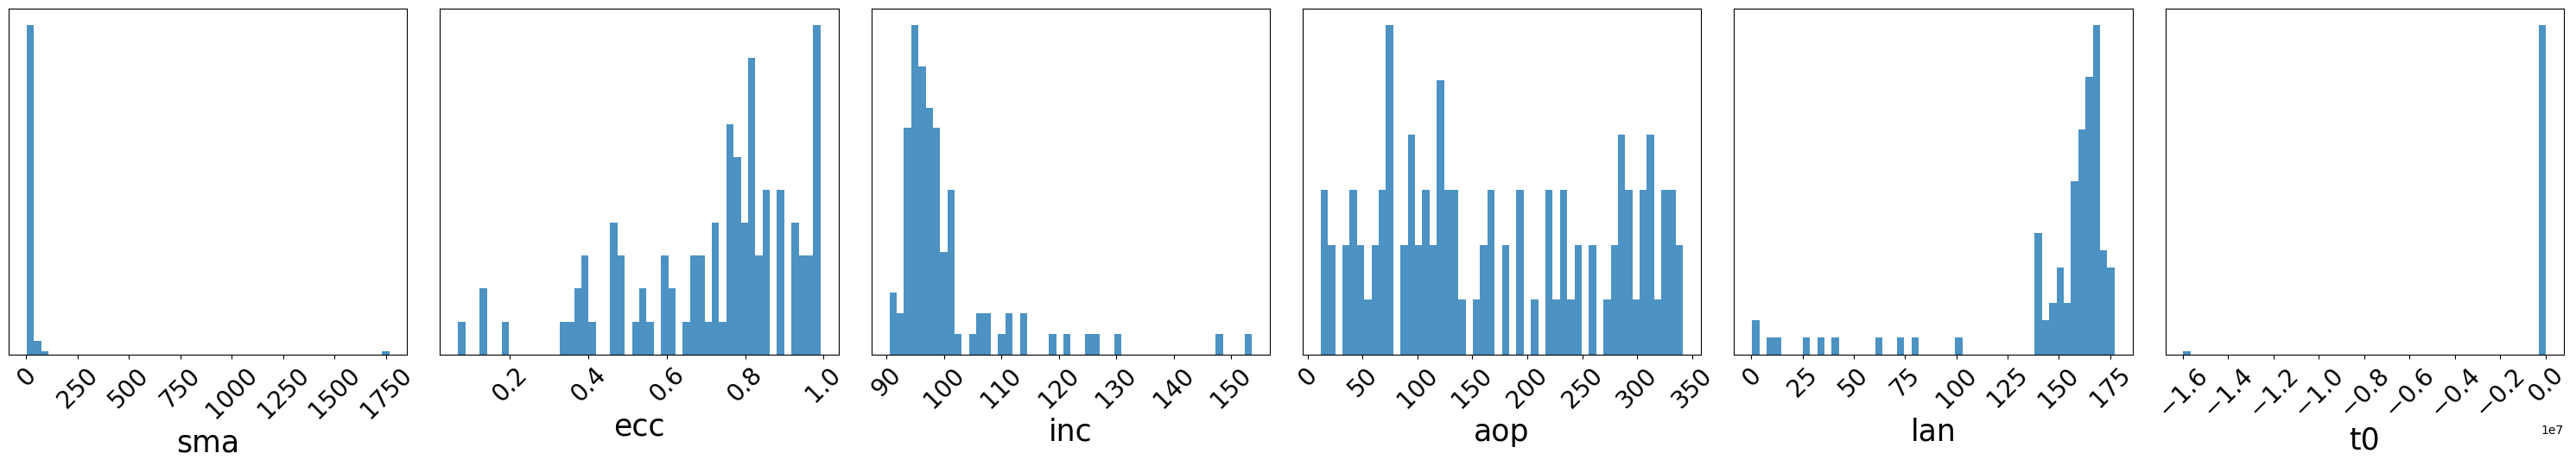

In [20]:
plt.style.use('default')
hists = results.PlotHists()

You can make adjustments to the histograms by calling the individual histogram axes:

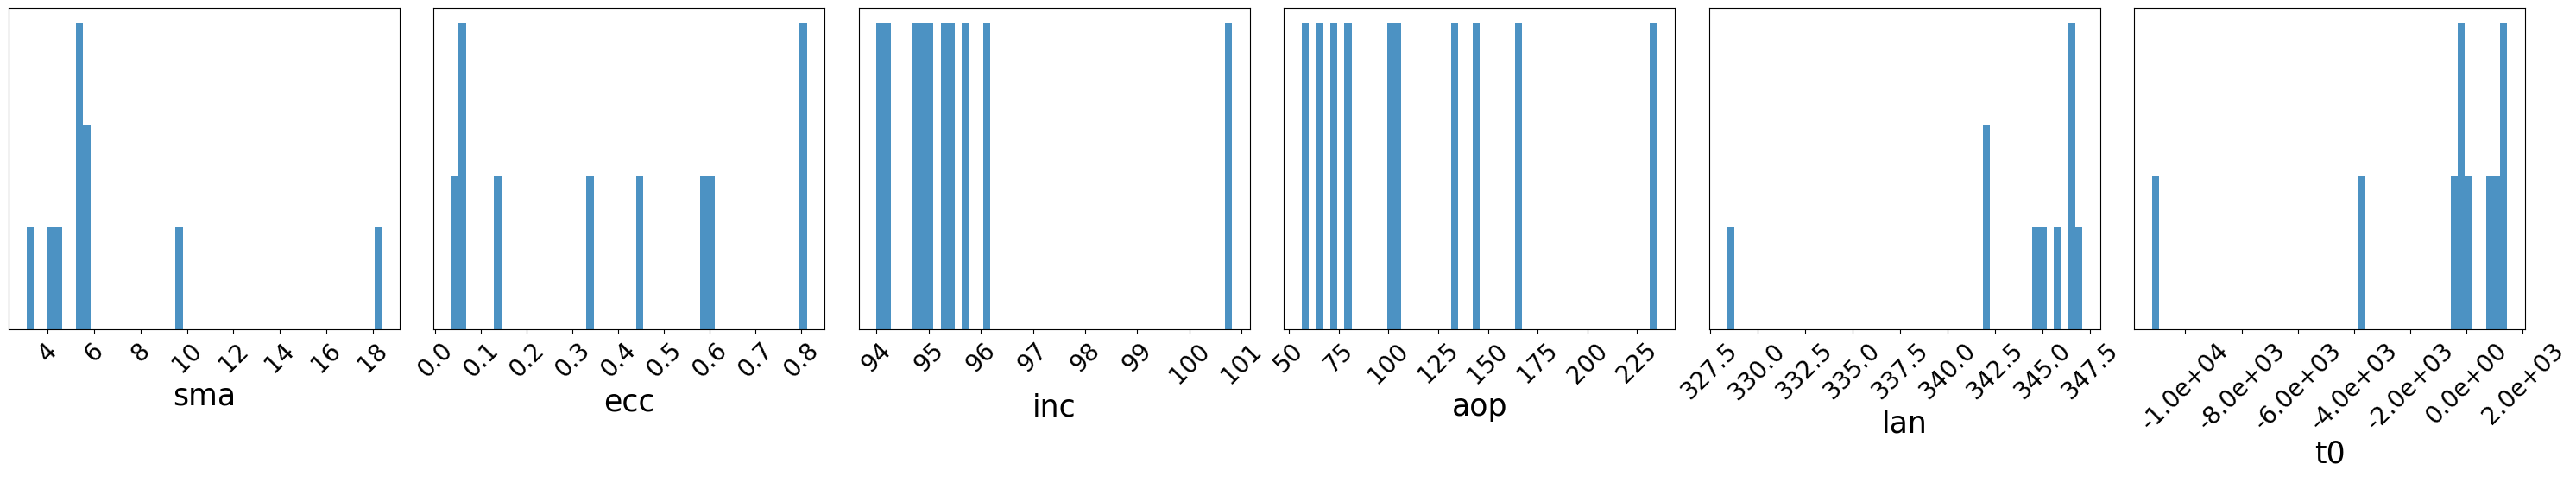

In [24]:
from matplotlib.ticker import FormatStrFormatter
# For example, change t0 to scientific notation:
hists.axes[-1].xaxis.set_major_formatter(FormatStrFormatter('%.1e'))
hists

Plot plane-of-sky orbits using ```PlotOrbits```.  If the orbit sample results are larger than 100, ```PlotOrbits``` will randomly select 100 orbits from the posterior sample to plot.

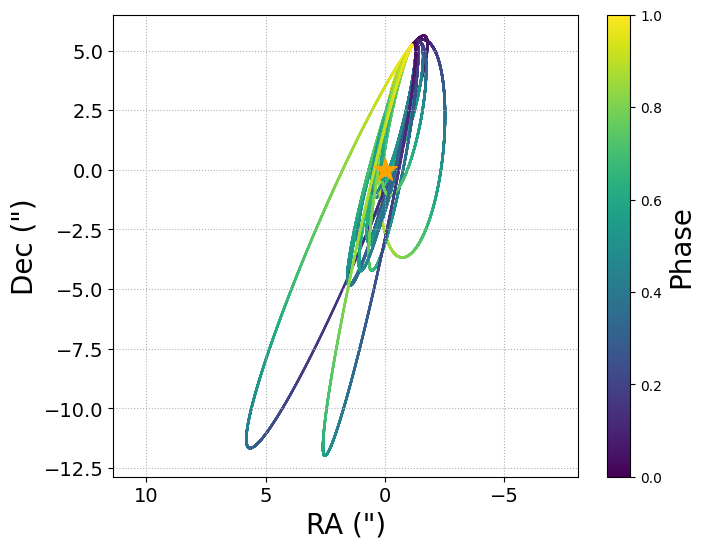

In [24]:
plotorbits = results.PlotOrbits()

If I want to plot fewer orbits, change the size keyword:

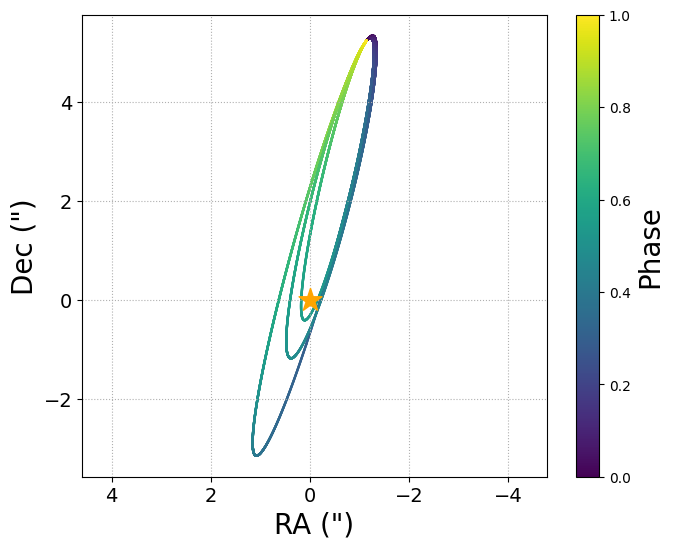

In [26]:
plotorbits = results.PlotOrbits(size = 3)

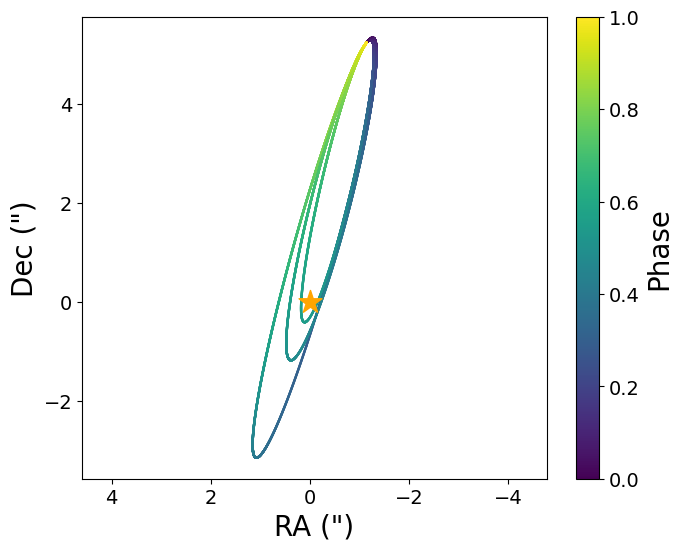

In [27]:
# the tick labels looks small
# on the colorbar, let's make them bigger:
plotorbits.axes[1].tick_params(labelsize=14)
# what if I don't want the grid lines?
plotorbits.axes[0].grid(b=False)
plotorbits

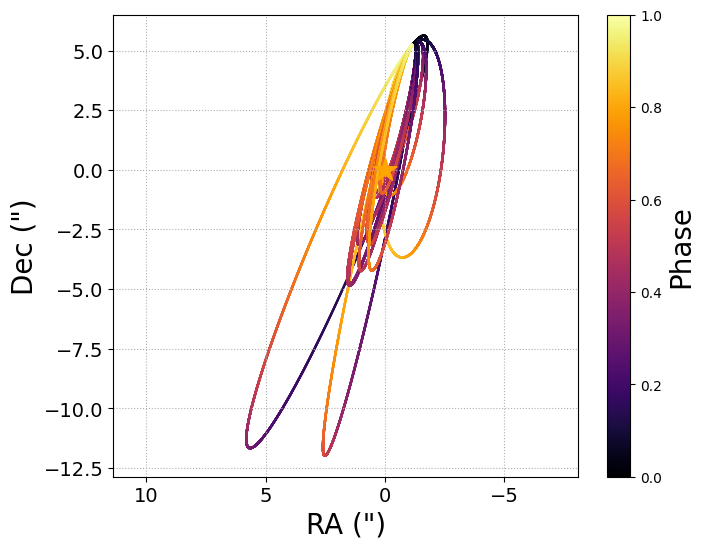

In [28]:
# What if I want a different color map?
plotorbits = results.PlotOrbits(cmap = 'inferno')

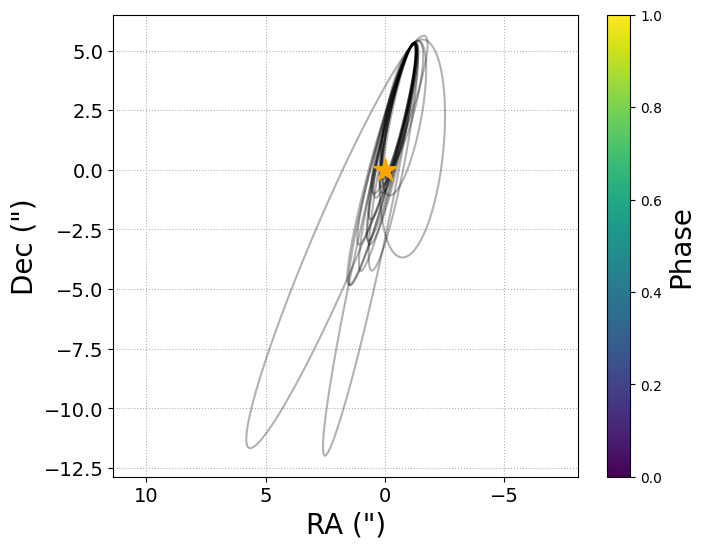

In [29]:
# Or no colormap at all?
plotorbits = results.PlotOrbits(color = False)

You can make a 3d plot with the plot3d keyword:

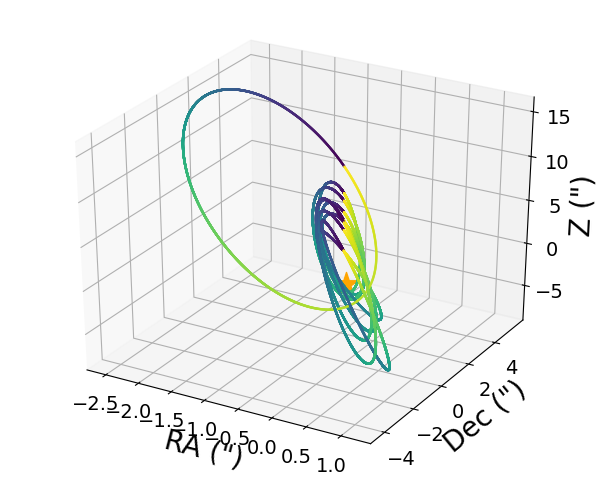

In [30]:
from lofti_redesign import Results
loaded_results = Results(limit_lan = False)
loaded_results.LoadResults("FitResults.from.a.previous.run.pkl")
plotorbits3d = loaded_results.PlotOrbits(plot3d = True)

```PlotSepPA``` plots the orbits in separation and position angle vs time.

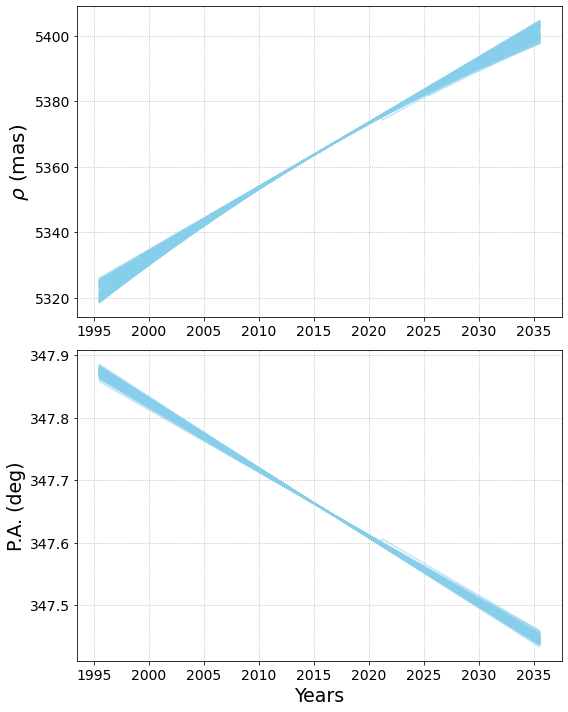

In [10]:
from lofti_gaiaDR2 import Results
loaded_results = Results(limit_lan = False)
loaded_results.LoadResults("FitResults.from.a.previous.run.pkl")
plotseppa = loaded_results.PlotSepPA()

You can added scatter plot of astrometric points to the plot.  To reproduce Fig 1b in Pearce et al. 2020 of DS Tuc AB Gaia fit compared to WDS astrometry points, read in the included csv of WDS astrometry and add to the plot:

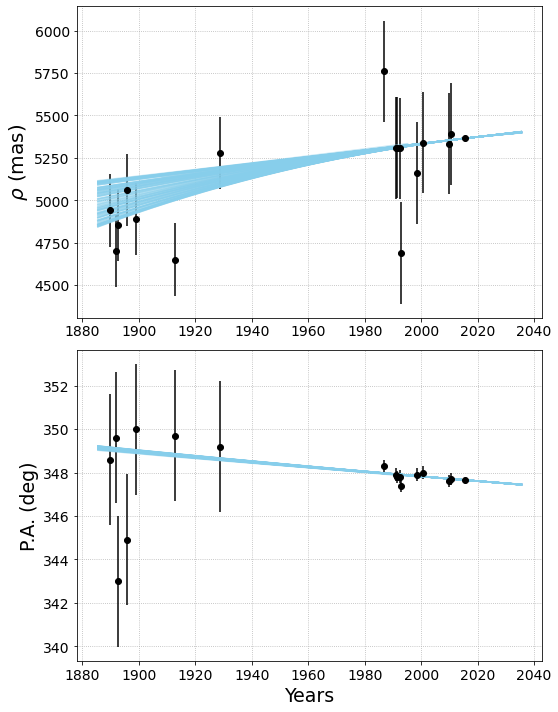

In [11]:
# Read in WDS astrometry:
import pandas as pd
WDS = pd.read_csv('WDS_DSTuc.csv')
# Adjust the time span of the plot to cover the range of WDS dates:
plotseppa = loaded_results.PlotSepPA(timespan=[130,20])
# Add the WDS scatter plot and error bars to the separation plot:
plotseppa.axes[0].errorbar(WDS['dates'],WDS['sep'], yerr = WDS['seperr'], color='black', ls='none')
plotseppa.axes[0].scatter(WDS['dates'],WDS['sep'], color = 'black', marker='o',zorder=10)
# Add to the position angle plot
plotseppa.axes[1].errorbar(WDS['dates'],WDS['pa'], yerr = WDS['paerr'], color='black', ls='none')
plotseppa.axes[1].scatter(WDS['dates'],WDS['pa'], color = 'black', marker='o',zorder=10)
